In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Sequential 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, Dropout, Dense, Flatten
from keras.models import Sequential
from keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator, preprocess

(array([  37.,   34.,   62.,  317.,  287., 3362.,   52.,   28.,   20.,
         126.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

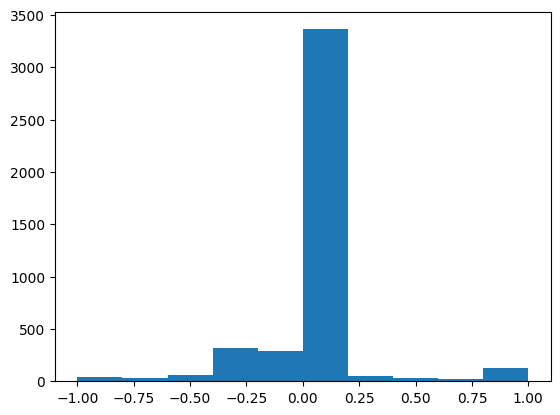

In [5]:
# Thư mục để dữ liệu
data_dir = 'B7'
# Đọc file driving_log.csv với các cột tương ứng
data_df = pd.read_csv(r'D:\GitHub\UEL-Course\Kì Hè Năm 3\1. Deep Learning\1. Thực hành lớp\B7\driving_log.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Lấy đường dẫn đến ảnh ở camera giữa, trái, phải
X = data_df[['center', 'left', 'right']].values
# Lấy góc lái của ô tô
y = data_df['steering'].values

# Vẽ histogram dữ liệu
plt.hist(y)

Do quá nhiều dữ liệu với góc lái ở 0 tức là để ô tô đi thẳng, nên ta sẽ loại bỏ bớt đi để tránh việc model có xu hướng dự đoán góc lái thiên về 0.

(array([  37.,   34.,   62.,  317.,  287., 1057.,   52.,   28.,   20.,
         126.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

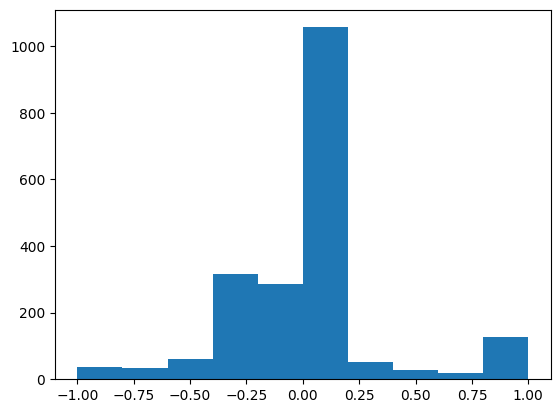

In [6]:
# Loại bỏ và chỉ lấy 1000 dữ liệu có góc lái ở 0
pos_zero = np.array(np.where(y==0)).reshape(-1, 1)
pos_none_zero = np.array(np.where(y!=0)).reshape(-1, 1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_none_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

Ta vẫn để giá trị góc lái ở 0 là nhiều nhất vì có thể phần nhiều thời gian của ô tô là đi thẳng thật. Việc histogram lệch bên trái không quá quan trọng vì ta dùng flip ảnh.

In [7]:
# Chia ra traing set và validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [9]:
# Xây dựng model
model = Sequential([
    Lambda(lambda x: (x / 127.5) - 1.0, input_shape=INPUT_SHAPE),
    Conv2D(24, (5, 5), activation='elu', strides=(2, 2)),
    Conv2D(36, (5, 5), activation='elu', strides=(2, 2)),
    Conv2D(48, (5, 5), activation='elu', strides=(2, 2)),
    Conv2D(64, (3, 3), activation='elu'),
    Conv2D(64, (3, 3), activation='elu'),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='elu'),
    Dropout(0.5),
    Dense(50, activation='elu'),
    Dense(10, activation='elu'),
    Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)               │ (None, 66, 200, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4

# Checkpoint này để nói cho model lưu lại model nếu validation loss thấp nhất
checkpoint = ModelCheckpoint('models/model-{epoch:03d}.keras', 
                             monitor='val_loss',
                             verbose=0,
                             save_best_only=save_best_only,
                             mode='auto')

# Dùng mean_squrared_error làm loss function
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

# Train model
H = model.fit(x=batch_generator(data_dir, X_train, y_train, batch_size, True),
              steps_per_epoch=samples_per_epoch,
              epochs=nb_epoch,
              validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
              validation_steps=len(X_valid),  # Sử dụng validation_steps để thay thế nb_val_samples
              callbacks=[checkpoint],
              verbose=1)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 186s 184ms/step - loss: 0.1334 - val_loss: 0.0548
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 127s 127ms/step - loss: 0.0991 - val_loss: 0.0545
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 121s 121ms/step - loss: 0.0898 - val_loss: 0.0483
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 104s 104ms/step - loss: 0.0885 - val_loss: 0.0543
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 104s 105ms/step - loss: 0.0889 - val_loss: 0.0582
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 106s 106ms/step - loss: 0.0968 - val_loss: 0.0565
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 103ms/step - loss: 0.1017 - val_loss: 0.0651
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 97s 98ms/step - loss: 0.1062 - val_loss: 0.1021
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 100s 100ms/step - loss: 0.1059 - val_loss: 0.1005
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 97s 97ms/step - loss: 0.1014 - val_loss: 0.1036


Vậy model ở epoch 3 có val_loss thấp nhất nên ta sẽ dùng model này để cho ô tô tự lái

In [21]:
from keras.models import load_model
from PIL import Image
import base64
from io import BytesIO

# Khởi tạo các biến tốc độ
MIN_SPEED = 10
MAX_SPEED = 25
speed_limit = MAX_SPEED
model_path = r'D:\GitHub\UEL-Course\Kì Hè Năm 3\1. Deep Learning\1. Thực hành lớp\B7\Test\models\model-003.keras'

# Tải mô hình
model = load_model(model_path)

# Dữ liệu mẫu từ input hoặc từ một stream dữ liệu thực tế
data = {
    "steering_angle": 0.0,  # giá trị mẫu, thay đổi theo dữ liệu thực tế
    "speed": 20.0,  # giá trị mẫu
    "image": "encoded_image_data"  # base64 encoded image data, giá trị mẫu
}

# Load và xử lý ảnh từ camera
image = Image.open(BytesIO(base64.b64decode(data["image"])))
image = np.asarray(image)
image = utils.preprocess(image)  # Gọi hàm preprocess từ utils nếu bạn có
image = np.array([image])  # Thêm một chiều cho batch

# Dự đoán góc lái từ ảnh
steering_angle = float(model.predict(image, batch_size=1))

# Điều chỉnh tốc độ dựa trên góc lái và tốc độ hiện tại
if float(data["speed"]) > speed_limit:
    speed_limit = MIN_SPEED  # giảm tốc độ
else:
    speed_limit = MAX_SPEED

throttle = 1.0 - steering_angle**2 - (float(data["speed"])/speed_limit)**2

# In ra kết quả
print('*****************************************************')
print('Steering Angle: {:.4f}, Throttle: {:.4f}, Speed: {:.4f}'.format(steering_angle, throttle, float(data["speed"])))

# Gửi lại dữ liệu về góc lái, tốc độ cho phần mềm để ô tô tự lái
# send_control(steering_angle, throttle)  # Giả sử bạn đã xác định hàm send_control

ValueError: The `{arg_name}` of this `Lambda` layer is a Python lambda. Deserializing it is unsafe. If you trust the source of the config artifact, you can override this error by passing `safe_mode=False` to `from_config()`, or calling `keras.config.enable_unsafe_deserialization().